In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.sparse import csr_matrix
import matplotlib.pylab as plt
import scipy.sparse as sps
from random import randint
import operator
df = pd.read_csv('online_retail_transaction.csv',header=None,index_col=None)
df.shape # dimensione originale

(4372, 4223)

In [124]:
def compute_band_matrix(original_dataset=None, dim_finale=1000, nome__file_item=None, num_sensibile=1):
    """
        Compute band_matrix , permutazione casuale di righe e colonne
        estrapola a caso item_sensibili
    """
    if original_dataset is not None and len(original_dataset) >= dim_finale and len(original_dataset.columns) >= dim_finale:
        # leggo nomi items
        file = open(nome__file_item, "r")
        items = file.read().splitlines()
        # permuto righe e colonne del df inizale e prendo le prime :dim_finale
        np.random.seed(seed=13)
        random_column = np.random.permutation(df.shape[1])[:dim_finale]
        random_row = np.random.permutation(df.shape[0])[:dim_finale]
        # recupero gli item selezionati nel relativo ordine == colonne
        items_reordered = [items[i] for i in random_column]
        # df selezionato e square
        
        # eliminare le righe nulle a priori
        df_square = df.iloc[random_row][random_column];
        # eliminare solo se items sensibili nulli
        
        # selezioni gli utlimi num_sensibili come item sensibili
        # check se esiste almeno un item sensibile

        # remove dati sensibili add zero --> compute RCM --> remove zero e add dati sensibili
        # df_sensibili = df_square[df_square.columns[-num_sensibile:]]
        # df_common_items = df_square[df_square.columns[0:-num_sensibile]]
        # zero_data_to_add = np.zeros(shape=(len(df_common_items),num_sensibile))
        # columns_to_add = ["temp_"+str(x) for x in range(0,num_sensibile)]
        # df_zeri = pd.DataFrame(zero_data_to_add, columns=columns_to_add,index=df_common_items.index,dtype='uint8')
        # df_square = pd.concat([df_common_items,df_zeri],axis=1)
        # print(df_zeri.shape) dim_finalexnum_sensibili
        # print(df_square.shape)
        # subplot with y condiviso

        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        
        # check che le colonne sensibili non siano nulle
        lista_sensibili = df_square.columns[-num_sensibile:]
        # plot matrice sparsa iniziale
        # plt
        ax1.spy(df_square, marker='.', markersize='1')
        #ax1.show()

        # applicazione algoritmo RCM
        sparse = csr_matrix(df_square)
        order = reverse_cuthill_mckee(sparse)

        # solo se add gli 0
        # riordino i dati sensibili
        # df_sensibili = df_sensibili.iloc[order]

        # ora devo prendere gli item selzionati prima e riordinarli ancora
        # secondo quello scritto in order quindi
        items_final = [items_reordered[i] for i in order]
        column_reordered = [df_square.columns[i] for i in order]
        # df bandizzato
        df_square_band = df_square.iloc[order][column_reordered]
        # plotto
        ax2.spy(df_square_band, marker='.', markersize='1')
        #ax2.show()
        plt.show()
        # banda dataframe inizale
        [i, j] = np.where(df_square == 1)
        bw = max(i-j) + 1
        print("Bandwidth first RCM", bw)

        # banda dataframe dopo RCM
        [i, j] = np.where(df_square_band == 1)
        bw = max(i-j) + 1
        print("Bandwidth after RCM", bw)
        return df_square_band, items_final, lista_sensibili



In [138]:

def check_conflict(dataframe, row_i, row_j, items_sensibili):
    # se hanno un items sensibile in comune allora sono in conflitto
    dati_sensibili_row_i = items_sensibili[np.where(dataframe.iloc[row_i][items_sensibili] == 1)]
    dati_sensibili_row_j = items_sensibili[np.where(dataframe.iloc[row_j][items_sensibili] == 1)]
    # create set
    set_j = set(dati_sensibili_row_j)
    set_i = set(dati_sensibili_row_i)
    # check intersection
    return len(set_i.intersection(set_j)) > 0


def compute_hist(dataframe, items_sensibili):
    hist = dict(dataframe[items_sensibili].sum())
    return hist


def compute_candidate_list(dataframe, indice_transizione_sensibile, alpha,p, item_sensibili, all_transazioni_sensibili):
    alpha_p = alpha*p
    lc = list()  # lista candidate
    k = 1
    # controllo gli alpha*p transazioni precedenti non sono in conflitto
    cond = max(indice_transizione_sensibile - alpha_p - k, -1)
    i = indice_transizione_sensibile - 1;
    while (i > cond):
        if i not in all_transazioni_sensibili:
            lc.append(i)
        else:
            if check_conflict(dataframe, indice_transizione_sensibile, i, item_sensibili):
                k = k + 1
            else:
                lc.append(i)
        cond = max(indice_transizione_sensibile - alpha_p - k, -1)
        i -= 1
        
    # alpha*p transizioni successive che non sono in conflitto
    k = 1
    cond = min(indice_transizione_sensibile + alpha_p + k, len(dataframe))
    i = indice_transizione_sensibile + 1
    while(i < cond):
        if i not in all_transazioni_sensibili:
            lc.append(i)
        else:
            if check_conflict(dataframe, indice_transizione_sensibile, i, items_sensibili):
                k = k + 1
            else:
                lc.append(i)
        cond = min(indice_transizione_sensibile + alpha_p + k, len(dataframe))
        i += 1
    
    error = False
    if len(lc) < p:
        error = True
        
    return lc,error


def selectBestTransactions(df, candidate_list, transaction_target, p, items_sensibili):
    all_items = list(df)
    QID_items = [x for x in all_items if x not in items_sensibili]

    #lista riportante gli item in comune con transactionTarget
    distance = list()    
    for row in candidate_list:
        list1 = df.iloc[transaction_target][QID_items]
        list2 = df.iloc[row][QID_items]
        #da queste due liste, devo escludere le transazioni sensibili.
        
        #num. elementi in comune di due liste
        distance.append(sum([x and y for x, y in zip(list1, list2)]))

    #ottengo i p-1 indici della lista candidata con distanza maggiore
    major_indexs = list()
    for i in range(0, p-1):
        max_index,max_value = max(enumerate(distance), key=operator.itemgetter(1))
        major_indexs.append(max_index)
        distance[max_index] = -1

    #seleziono gli indici delle righe del dataframe con maggior QIitems in comune
    best_rows = list()
    for i in major_indexs:
        best_rows.append(candidate_list[i])

    return best_rows




In [149]:
def CAHD(dataframe_bandizzato_temp, items_sensibili, nome_item, grado_privacy, alfa=3):
    """
        funzione per il calcolo di CAHD su un dataframe_bandizzato dopo RCM
        con gli items sensibili (vedi paper per teoria)
    """
    # temp per non modificare quello originale
    dataframe_bandizzato = dataframe_bandizzato_temp.copy()
    #print(len(dataframe_bandizzato))
    
    # calcolo istogramma per i dati sensibili (visto come dizionario)
    hist = compute_hist(dataframe_bandizzato, items_sensibili)
    
    # lunghezza del dataframe
    remaining = len(dataframe_bandizzato)
    
    # inidice delle righe delle transazioni sensibili non ripetute
    # indice delle transizioni sensibili con mapping 1-1 con item_sensibile_per_transizione
    # transazioni_sensibili_completa[i] --> indice della transizione
    # item_sensibile_per_transazioni[i] --> item sensibile per la transizione sopra
    transazioni_sensibili = set(list(np.where(dataframe_bandizzato[items_sensibili] == 1)[0]))
    transazioni_sensibili_completa = list(np.where(dataframe_bandizzato[items_sensibili] == 1)[0])
    # item sensibili della transazione iesime
    item_sensibile_per_transazioni = list(np.where(dataframe_bandizzato[items_sensibili] == 1)[1])
    
    # riempo il dizionario (hash_map) indicizzata con il numero della riga
    for t in transazioni_sensibili:
        index_t = np.where(np.array(transazioni_sensibili_completa) == t)[0]

    lc = dict()     # lista candidata
    
    #FORMO IL DATAFRAME ANONIMIZZATO [item sensibili sono riportati a destra]
    #Nota: codice aggiunto. Molti di questi argomenti possono essere passati esternamente e passati a loro volta 
    #a funzioni interne
    all_items = list(df_square.columns)
    QID_items = [x for x in all_items if x not in items_sensibili]
    columns_list = QID_items.copy()
    for x in items_sensibili:
        columns_list.append(x)
    # dataframe anonimizzato dopo aver sopostato tutte le colonne degli item sensibili a destra
    dataframe_anonimizzato = pd.DataFrame(columns=columns_list,index=df_square.index)
    dict_group = list()
    
    #FIX: CAMBIO LA MEMORIZZAZIONE DA NUM.RIGA A LABEL RIGA
    # index delle row del datframe bandizzato relativo alle row sensibili
    id_sensitive_transaction = dataframe_bandizzato.iloc[list(transazioni_sensibili)].index
    #print("id",id_sensitive_transaction)
    
    #Ciclo finchè ho gruppi da anonimizzare
    done = False
    
    # lista dei gruppi con i relativi dati sensibili all'interno
    lista_gruppi =list()
    sd_gruppi = list()
    
    #indice che cicla tra gli id_delle transazioni sensibili
    ts_index = 0
    while(not done):
        
        #se ho terminato di scorrere la lista delle transazioni sensibili esco dal ciclo
        if(ts_index > len(id_sensitive_transaction)-1):
            done = True
            break
        
        #seleziono la iesima transzione sensibile
        q = id_sensitive_transaction[ts_index]
        #passo da label a num.di riga
        t = dataframe_bandizzato.index.get_loc(q)
        
        #nel caso di cancellazioni, devo aggiornare la lista degli indici delle transazioni sensibili
        transazioni_sensibili = list()
        for i in id_sensitive_transaction:
            transazioni_sensibili.append(dataframe_bandizzato.index.get_loc(i))
    
        #lista candidata LC 
        lc,errore = compute_candidate_list(dataframe_bandizzato, t, alfa, grado_privacy, items_sensibili, transazioni_sensibili)
        
        if not errore:
            group = selectBestTransactions(dataframe_bandizzato, lc, t, grado_privacy,items_sensibili)
            #aggiungo la transazione bersaglio
            group.append(t)
            
            # somma degli items sensibili del gruppo iesimo relativo
            selected_sensitive_items = dataframe_bandizzato.iloc[group][items_sensibili].sum()
            # temp hist
            temp_hist = hist.copy()
            # aggiorno le occorrenze di ogni item sensbile
            
            for index in selected_sensitive_items.index:
                temp_hist[index] -= selected_sensitive_items.loc[index] 
            
            # controllo se il gruppo creato va bene
            found = False
            for index in temp_hist.keys():
                # se non si può più soddisfare il grado di privacy
                if temp_hist[index] * grado_privacy > remaining:
                    found = True
                    ts_index += 1
                    break
                    
            # se il gruppo invece va bene
            if not found:
                
                # update hist
                hist = temp_hist.copy()
                #DEVO RIMUOVERE EVENTUALI TRANSAZIONI SENSIBILI COMPRESE NEL GRUPPO DA id_sensitive_transaction
                label_group = dataframe_bandizzato.iloc[group].index
                id_sensitive_transaction = [x for x in id_sensitive_transaction if x not in label_group]
                
                # indice iesimo -> indice delle transazioni del gruppo iesimo 
                dict_group.append(dataframe_bandizzato.index[group])
                
                # metto i QID nel datframe anonimizzato
                dataframe_anonimizzato.loc[list(dataframe_bandizzato.index[group])] = dataframe_bandizzato.loc[list(dataframe_bandizzato.index[group])]
                lista_gruppi.append(dataframe_bandizzato.loc[list(dataframe_bandizzato.index[group]),QID_items])
                
                for index in list(dataframe_bandizzato.index[group]):
                    # metto la somma dei SD del gruppo per ogni row del gruppo
                    dataframe_anonimizzato.loc[index][selected_sensitive_items.index] = selected_sensitive_items
                
                sd_gruppi.append(selected_sensitive_items) # aggiungo somma item sensibili relativi al gruppo iesimo

                # le droppo dal df iniziale
                dataframe_bandizzato = dataframe_bandizzato.drop(list(dataframe_bandizzato.index[group]))

                # compute row rimanenti
                remaining = len(dataframe_bandizzato.index)
                
        else:
            ts_index += 1
            
    #terminato il ciclo di formazione dei gruppi, mi rimane un supergruppo con le transazioni sensibili rimanenti o meno.
    
    # somma item sensibili nel gruppo rimasto
    #for i in range(0,dataframe_bandizzato.shape[0]):
    #    transaction = dataframe_bandizzato.index[i]
    #    dataframe_anonimizzato.loc[transaction] = dataframe_bandizzato.iloc[i]
    
    # update del dataframe anonimizzato con il super gruppo finale 
    selected_sensitive_items = dataframe_bandizzato[items_sensibili].sum()
    dataframe_anonimizzato.loc[dataframe_bandizzato.index] = dataframe_bandizzato   
    # metto la somma degli item
    for index in list(dataframe_bandizzato.index):
        dataframe_anonimizzato.loc[index,items_sensibili]= selected_sensitive_items
    lista_gruppi.append(dataframe_bandizzato[QID_items])
    sd_gruppi.append(selected_sensitive_items)
    # del datframe iniziale
    dataframe_bandizzato = None
    
    return dataframe_anonimizzato,lista_gruppi,sd_gruppi


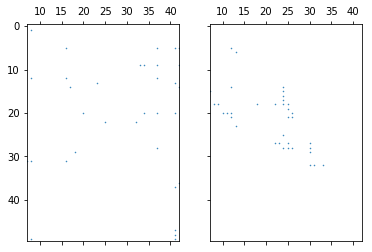

Bandwidth first RCM 42
Bandwidth after RCM 11
conflitoo 32 3581
conflitoo 32 668
conflitoo 32 3987
conflitoo 15 2491
conflitoo 16 2555
conflitoo 16 2491
conflitoo 17 3899
conflitoo 17 2555
conflitoo 17 2491
conflitoo 18 3399
conflitoo 18 3899
conflitoo 18 2555
conflitoo 18 2491


,2835,1108,1669,1736,1335,3822,1640,1830,27,3577,...,4188,1746,4031,369,2507,1236,407,2207,459,3608
628,0,0,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,2,0,0,0
1282,1,0,1,0,0,0,0,0,0,0,...,0,1,3,0,0,0,2,0,0,0
2090,0,0,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,2,0,0,0
2678,0,0,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,2,0,0,0
1396,0,0,0,1,0,0,0,0,0,0,...,0,1,3,0,0,0,2,0,0,0
1179,0,0,0,0,0,0,0,0,0,0,...,0,6,1,1,1,0,0,0,0,0
2686,0,0,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,2,0,0,0
3317,0,0,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,2,0,0,0
2935,0,0,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,2,0,0,0
3101,0,0,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,2,0,0,0


In [155]:
df_square,items,items_sensibili = compute_band_matrix(original_dataset = df, dim_finale = 50, nome__file_item="lista_items.txt",num_sensibile=10)
dataframe_anonimizzato,lista_gruppi,sd_gruppi = CAHD(df_square,items_sensibili,[],10)
dataframe_anonimizzato

In [156]:
sd_gruppi

[4188    0
 1746    6
 4031    1
 369     1
 2507    1
 1236    0
 407     0
 2207    0
 459     0
 3608    0
 dtype: int64, 4188    0
 1746    1
 4031    3
 369     0
 2507    0
 1236    0
 407     2
 2207    0
 459     0
 3608    0
 dtype: int64]

In [132]:
items_sensibili

Int64Index([3457, 1310, 2453, 185, 1974, 2229, 578, 4207, 2024, 230], dtype='int64')

In [146]:
lista_gruppi[4]

,2835,1108,1669,1736,1335,3822,1640,1830,27,3577,...,2783,1363,1216,233,928,2619,3437,4175,797,1688
3899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1976,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3187,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
